# **Inferência**

## **Instruções**

>- Carregar o peso (`modelo_pneumonia_final.keras`) no /content: [Link](https://drive.google.com/file/d/1GhtfY3Nml6MWo6kc6v1RuNSQjVW9f8ys/view?usp=sharing)
>- Objeto de inferencia: Para fazer a inferencia basta carregar a imagem de um<br> **raio-x** no /content e renomeá-lo pra `raio-x.jpeg` que a mágica acontece.

**Obs.: Certifiquesse dos nomes estarão corretas para o caso da imagem estar com uma extensão de imagem diferente como `.png` altere diretamente no código, o caminho da imagem estar nas primeiras linhas**

🧠 Calculando TTA (5x)...
📍 Posição do pico de ativação: (np.int64(0), np.int64(285)) (shape: (300, 300))


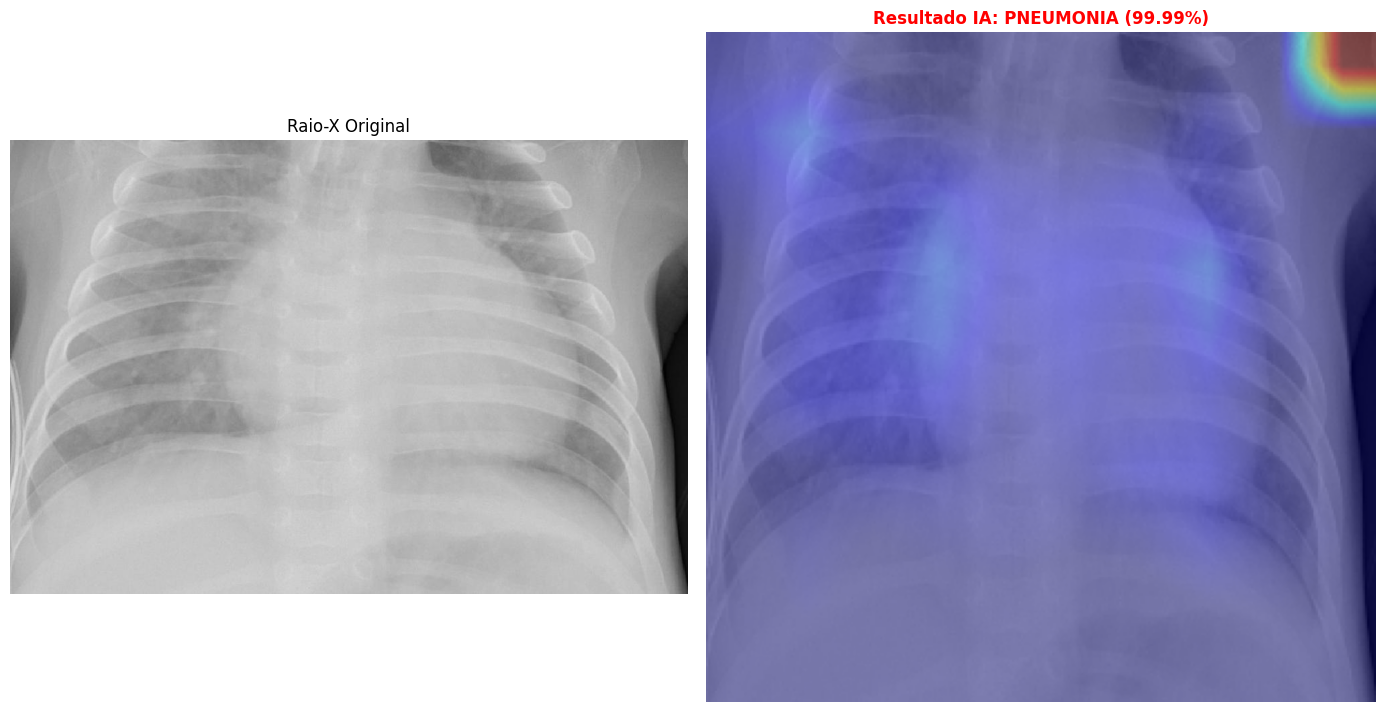

✅ Score Médio TTA: 0.999891


In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision

# 1. Forçar float32 para o Grad-CAM (evita erros de half tensor do mixed_float16)
mixed_precision.set_global_policy('float32')

# 2. Carregamento do Modelo
model_path = '/content/modelo_pneumonia_final.keras'
melhor_modelo = tf.keras.models.load_model(model_path)

# 3. Configurações
image_path = '/content/raio-x.jpeg'
inner_layer_name = "top_activation"

# 4. Pré-processamento idêntico ao treino
def custom_preprocessing(img):
    img_uint8 = img.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    res = np.zeros_like(img_uint8)
    for i in range(3):
        res[:,:,i] = clahe.apply(img_uint8[:,:,i])
    return tf.keras.applications.efficientnet.preprocess_input(res.astype(np.float32))

# 5. Função Grad-CAM
def make_gradcam_heatmap(img_array, model, inner_layer_name):
    base_model = model.layers[0]  # EfficientNetB3

    grad_model = Model(
        inputs=base_model.inputs,
        outputs=[base_model.get_layer(inner_layer_name).output, base_model.output]
    )

    # Garante float32
    img_array = tf.cast(img_array, tf.float32)

    with tf.GradientTape() as tape:
        conv_outputs, base_output = grad_model(img_array)
        tape.watch(conv_outputs)

        # Passa pelas camadas restantes (cabeça de classificação)
        x = tf.cast(base_output, tf.float32)
        for layer in model.layers[1:]:
            x = layer(x)

        loss = x[:, 0]

    grads = tape.gradient(loss, conv_outputs)

    output = tf.cast(conv_outputs[0], tf.float32)
    grads  = tf.cast(grads[0], tf.float32)

    # Guided Grad-CAM
    guided_grads = (
        tf.cast(output > 0, tf.float32) *
        tf.cast(grads  > 0, tf.float32) *
        grads
    )

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.dot(output.numpy(), weights.numpy())

    # Processamento do heatmap
    cam = cv2.resize(cam, (300, 300))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)
    return heatmap

# 6. Inferência com TTA (5x) e Visualização
if os.path.exists(image_path):
    img_orig    = cv2.imread(image_path)
    img_orig    = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_orig, (300, 300))

    # TTA com horizontal_flip=True para verificar viés de dataset
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=custom_preprocessing,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,  # ativado para mitigar viés das marcações R/L
        fill_mode='nearest'
    )

    print("🧠 Calculando TTA (5x)...")
    preds = [
        melhor_modelo.predict(
            next(datagen.flow(np.expand_dims(img_resized, 0), batch_size=1)),
            verbose=0
        ) for _ in range(5)
    ]
    score_final = np.mean(preds)

    # Gerar Heatmap
    img_pre = np.expand_dims(custom_preprocessing(img_resized), 0)
    heatmap  = make_gradcam_heatmap(img_pre, melhor_modelo, inner_layer_name)

    # Diagnóstico: posição do pico de ativação
    pico = np.unravel_index(np.argmax(heatmap), heatmap.shape)
    print(f"📍 Posição do pico de ativação: {pico} (shape: {heatmap.shape})")

    # Overlay colorido
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    superimposed  = cv2.addWeighted(img_resized, 0.6, heatmap_color, 0.4, 0)

    # Plot
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(img_orig)
    plt.title("Raio-X Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    res_text = 'PNEUMONIA' if score_final > 0.5 else 'NORMAL'
    plt.title(
        f"Resultado IA: {res_text} ({score_final:.2%})",
        color='red' if res_text == 'PNEUMONIA' else 'green',
        fontweight='bold'
    )
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(f"✅ Score Médio TTA: {score_final:.6f}")

else:
    print("❌ Imagem não encontrada.")